# Regresión logística con SKLearn

Vamos a realizar un ejercicio algo inusual, pero que nos ayudará a entender cómo funciona una regresión logística para clasificación binaria. 

El conjunto de datos que usaremos es el de las r"elaciones amorosas" que viene con Statsmodels. Procede de una encuesta realizada a mujeres en 1974 por la revista Redbook, en la que se preguntaba a las mujeres casadas sobre su participación en relaciones extramatrimoniales. Hay más información sobre el estudio en un artículo de 1978 del Journal of Political Economy. El artículo es algo polémico, sin embargo, el dataset ha sido utilizado en varias ocasiones para analizar la probabilidad de que una mujer (en 1974) sea infiel en su matrimonio. 

## Descripción del data set

Descripción de las variables
El conjunto de datos contiene 6366 observaciones de 9 variables:

- rate_marriage: valoración de la mujer sobre su matrimonio (1 = muy malo, 5 = muy bueno)
- age: edad de la mujer
- yrs_married: número de años de matrimonio
- children: número de hijos
- religious: valoración de la mujer sobre su grado de religiosidad (1 = no religiosa, 4 = muy religiosa)
- educ: nivel de educación (9 = escuela primaria, 12 = escuela secundaria, 14 = algunos estudios universitarios, 16 = graduado universitario, 17 = algunos estudios de posgrado, 20 = título avanzado)
- occupation: ocupación de la mujer (1 = estudiante, 2 = agricultora/semi-cualificada/sin cualificar, 3 = "cuello blanco", 4 = profesora/enfermera/escritora/técnica/cualificada, 5 = directiva/empresaria, 6 = profesional con título superior)
- occupation_husb: ocupación del marido (misma codificación que la anterior)
- affairs: tiempo dedicado a las relaciones extramatrimoniales

## Planteamiento del Problema

Decidí tratar esto como un problema de clasificación creando una nueva variable binaria affair (¿tuvo la mujer al menos una aventura?) e intentando predecir la clasificación para cada mujer.

Skipper Seabold, uno de los principales colaboradores de Statsmodels, hizo una clasificación similar en su demostración de Statsmodels en un encuentro de Statistical Programming DC. Sin embargo, utilizó Statsmodels para la clasificación (mientras que yo estoy usando scikit-learn), y trató las variables de ocupación como continuas (mientras que yo las estoy tratando como categóricas).



In [52]:
# !pip install scikit-plot

In [53]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from patsy import dmatrices
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import metrics
import seaborn as sns
import scikitplot as skplt


In [3]:
# load dataset
dta = sm.datasets.fair.load_pandas().data

# add "affair" column: 1 represents having affairs, 0 represents not
dta['affair'] = (dta.affairs > 0).astype(int)

# EDA

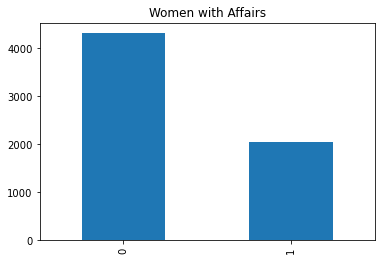

In [14]:
dta.affair.value_counts().plot(
    kind="bar",
    title="Women with Affairs"
);

In [6]:
dta.groupby('affair').mean()

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs
affair,,,,,,,,,
0,4.329701,28.390679,7.989335,1.238813,2.504521,14.322977,3.405286,3.833758,0.000000
1,3.647345,30.537019,11.152460,1.728933,2.261568,13.972236,3.463712,3.884559,2.187243


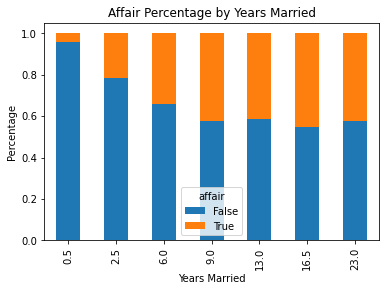

In [8]:
affair_yrs_married = pd.crosstab(dta.yrs_married, dta.affair.astype(bool))
affair_yrs_married.div(affair_yrs_married.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Affair Percentage by Years Married')
plt.xlabel('Years Married')
plt.ylabel('Percentage')
plt.show()

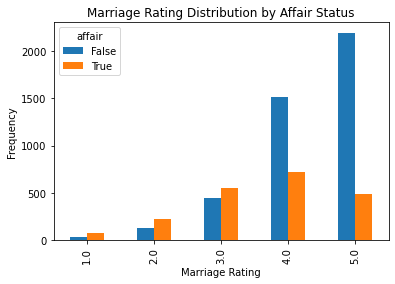

In [16]:
# barplot of marriage rating grouped by affair (True or False)
pd.crosstab(dta.rate_marriage, dta.affair.astype(bool)).plot(kind='bar')
plt.title('Marriage Rating Distribution by Affair Status')
plt.xlabel('Marriage Rating')
plt.ylabel('Frequency');

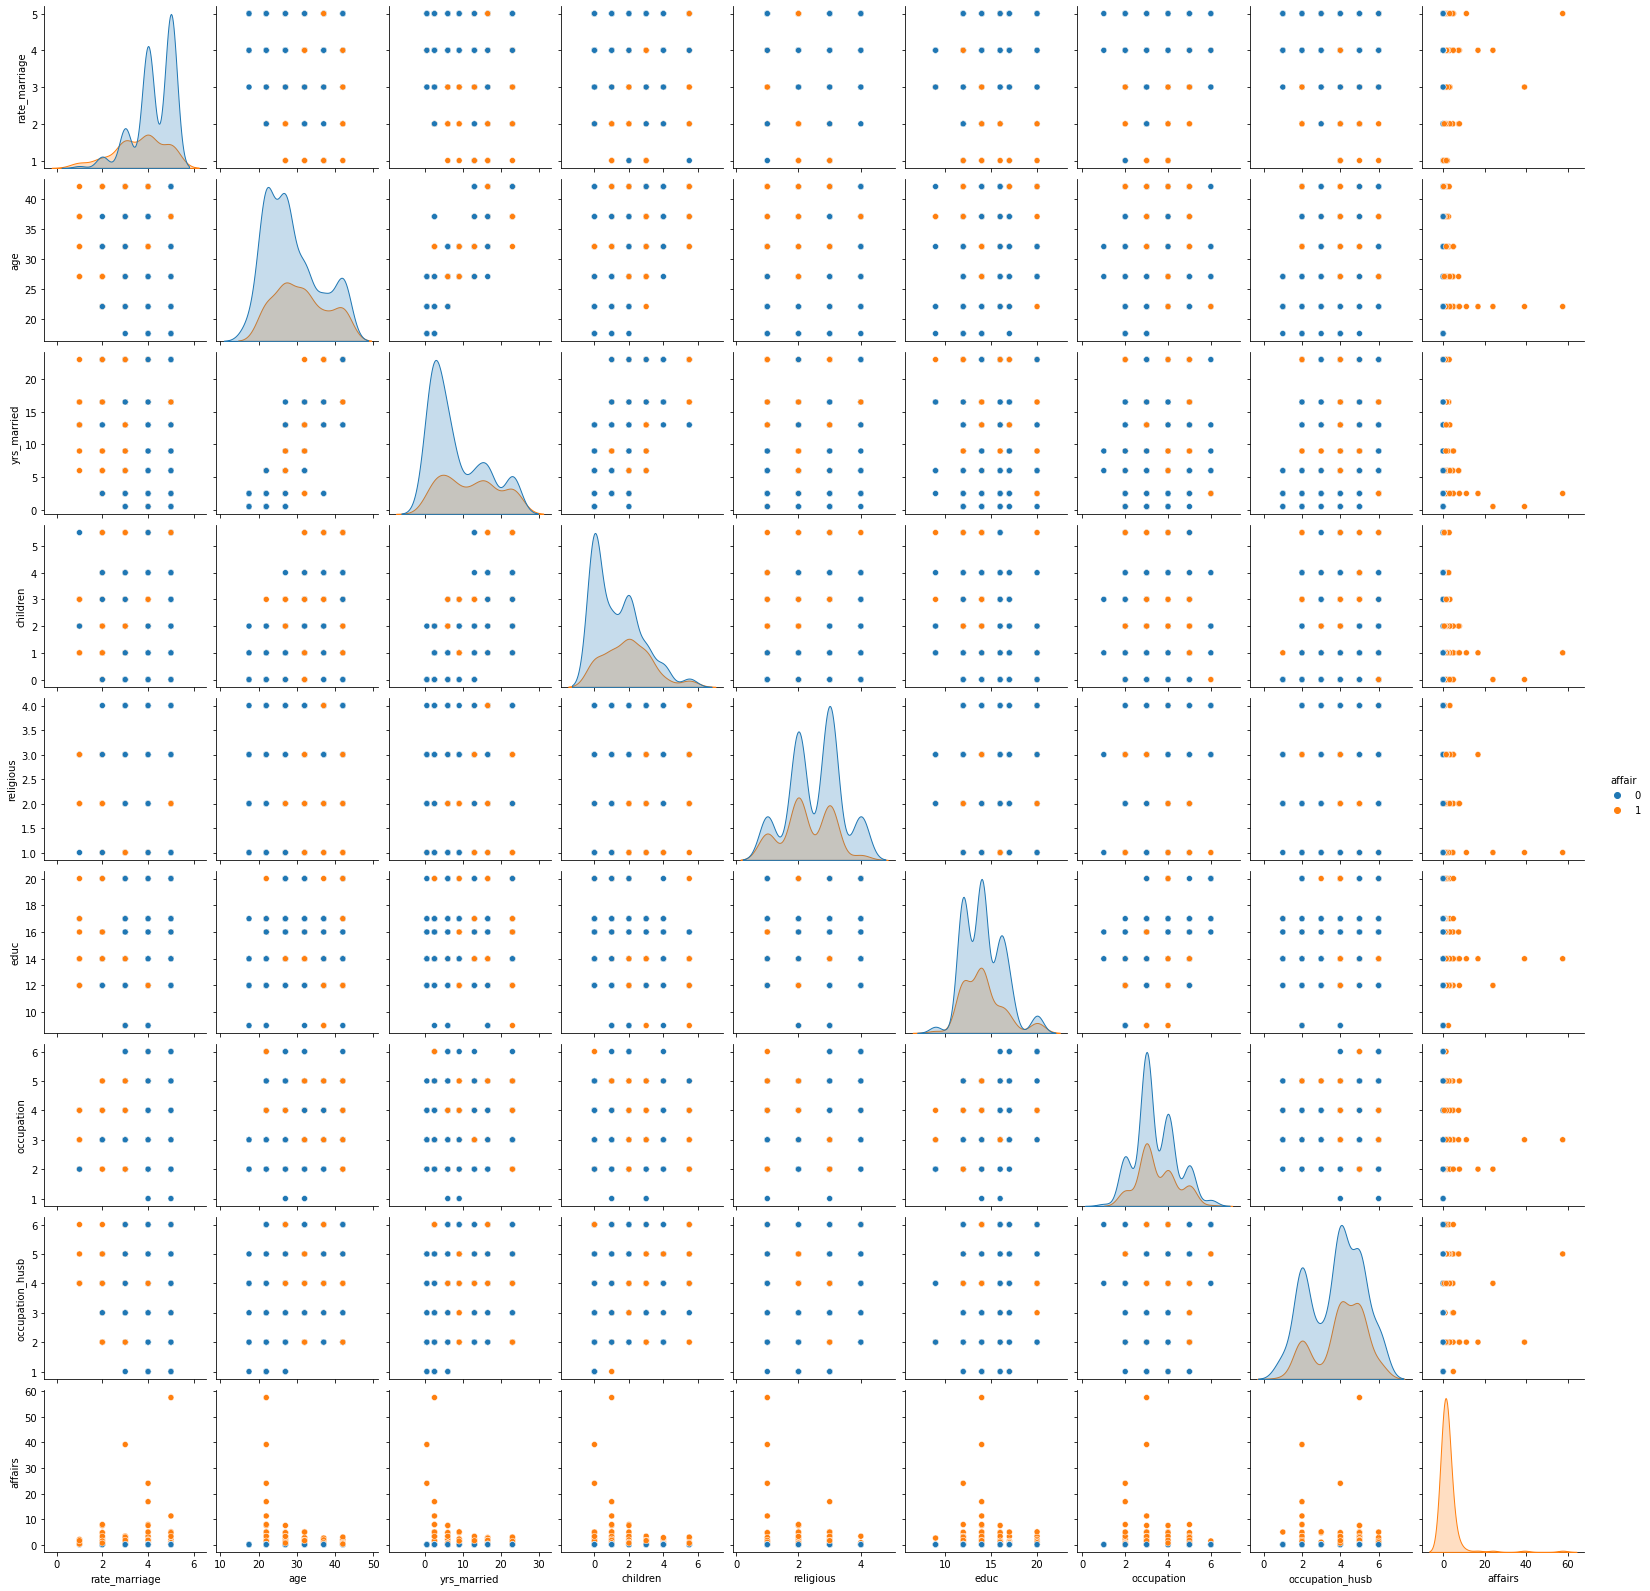

In [19]:
sns.pairplot(
    dta.sample(500), hue="affair"
)

## Preparar los datos para la regresión logística
Para preparar los datos, quiero añadir una columna de intercepción, así como variables ficticias para la ocupación y occupation_husb, ya que las estoy tratando como variables categoriales. La función dmatrices del módulo `patsy` puede hacerlo utilizando el lenguaje de fórmulas.

Pandas tiene una función que te podría ayudar a alcanzar lo mismo llamada pd.get_dummies, sin usar el lenguaje de formulas. Puedes utilizar cualquiera de las dos!

In [25]:
# create dataframes with an intercept column and dummy variables for
# occupation and occupation_husb
y, X = dmatrices('affair ~ rate_marriage + age + yrs_married + children + \
                  religious + educ + C(occupation) + C(occupation_husb)',
                  dta, return_type="dataframe")
print(X.columns)

Index(['Intercept', 'C(occupation)[T.2.0]', 'C(occupation)[T.3.0]',
       'C(occupation)[T.4.0]', 'C(occupation)[T.5.0]', 'C(occupation)[T.6.0]',
       'C(occupation_husb)[T.2.0]', 'C(occupation_husb)[T.3.0]',
       'C(occupation_husb)[T.4.0]', 'C(occupation_husb)[T.5.0]',
       'C(occupation_husb)[T.6.0]', 'rate_marriage', 'age', 'yrs_married',
       'children', 'religious', 'educ'],
      dtype='object')


In [26]:
# los nombres son algo incómodos, los simplifico
# fix column names of X
X = X.rename(
    columns = {
        'C(occupation)[T.2.0]':'occ_2',
        'C(occupation)[T.3.0]':'occ_3',
        'C(occupation)[T.4.0]':'occ_4',
        'C(occupation)[T.5.0]':'occ_5',
        'C(occupation)[T.6.0]':'occ_6',
        'C(occupation_husb)[T.2.0]':'occ_husb_2',
        'C(occupation_husb)[T.3.0]':'occ_husb_3',
        'C(occupation_husb)[T.4.0]':'occ_husb_4',
        'C(occupation_husb)[T.5.0]':'occ_husb_5',
        'C(occupation_husb)[T.6.0]':'occ_husb_6'
    }
)
# Reto, cómo puedo automatizar este cambio?

In [27]:
# aplanamos Y para que tome la forma que busca SKLEARN
y = np.ravel(y)

# El Modelo

La regresión logística es un modelo lineal, prácticamente una regresión lineal, sin embargo los valores son luego pasados por una función sigmoide que te devuelve valores entre 0 y 1. 
El output por ello, es una probabilidad que nos ayuda a clasificar de forma binaria, como en este caso, probabilidad de que una mujer sea infiel en su matrimonio.

In [28]:
# instantiate a logistic regression model, and fit with X and y
model = LogisticRegression()
model = model.fit(X, y)

# check the accuracy on the training set
model.score(X, y)

/Users/e0449486/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.7260446120012567

73 % es algo razonable, pero veamos si en realidad somos mejores que simplemente predecir siempre la clase mayoritaria (no infiel en este caso)

In [29]:
y.mean()

0.3224945020420987

o lo que es equivalente, dividir total de 0s por total de observaciones

In [31]:
dta.affair.value_counts() / len(dta.affair) 

0    0.677505
1    0.322495
Name: affair, dtype: float64

Es decir, si siempre predecimos NO tendremos un 68 % de accuracy, nuestro modelo es apenas mejor que la tasa de error nula. Hay mucho potencial de mejora, pero sigamos adelante, veamos los coeficientes.


In [42]:
coeffs = pd.DataFrame(
    model.coef_[0],
    index=X.columns,
    columns=['coeff']
)
coeffs

,coeff
Intercept,1.372688
occ_2,0.086894
occ_3,0.365176
occ_4,0.122427
occ_5,0.726109
occ_6,0.268323
occ_husb_2,0.286086
occ_husb_3,0.415861
occ_husb_4,0.242206
occ_husb_5,0.268632


<AxesSubplot:>

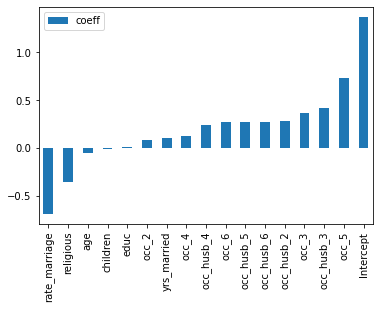

In [43]:
coeffs.sort_values("coeff").plot(kind="bar")

# Evaluación del modelo utilizando un set de validación.

Nos ayudará a preveenir el overfitting, además de asegurarnos de que nuestro modelo mantiene su calidad en datos no vistos.

In [44]:
# evaluate the model by splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)
model2 = LogisticRegression()
model2.fit(X_train, y_train)


/Users/e0449486/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

# Probabilidad de Affair

Podemos acceder a la predicción binaria (prob > 0.5) o directamente a su probabilidad utilizando diferentes funciones de Sklearn

In [45]:
# Output binario
predicted = model2.predict(X_test)
print(predicted[:4])

[0. 1. 0. 0.]


In [46]:
# Probabilidad 
probs = model2.predict_proba(X_test)
print(probs[:4]) # prob 0, prob 1

[[0.68073784 0.31926216]
 [0.49499055 0.50500945]
 [0.69102496 0.30897504]
 [0.70160553 0.29839447]]


## Métricas de evaluación y Cross Validation

El accuracy no es una métrica del todo completa para evaluar nuestro modelo. Muchas veces es útil complementar la evaluación con otras métricas. Por ejemplo recall, f1, ROC, etc. SKlearn nos permite calcularlas automáticamente. 
En este caso nos centraremos en el valor ROC - AUC: 
Esta explicación es muy útil. [ROC-AUC](https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5#:~:text=the%20multiclass%20model%3F-,What%20is%20the%20AUC%20%2D%20ROC%20Curve%3F,capable%20of%20distinguishing%20between%20classes.)

En resumen, un valor de ROC 1 nos dirá que somos capaces de diferenciar entre clases perfectamente, un valor de 0.5 indica que no tenemos capacidad de diferenciar entre clases (nula) y finalmente un valor de 0 indica que tenemos las clases invertidas en nuestro clasificador, es decir que predecimos 0 cuando en realidad es 1



In [47]:
print(metrics.accuracy_score(y_test, predicted))
print("--------------------------------")
print(metrics.roc_auc_score(y_test, probs[:, 1]))

0.7261780104712042
--------------------------------
0.7583702331326232


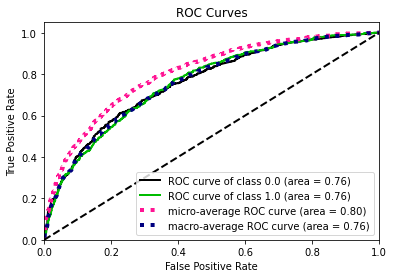

In [56]:
# Plot de la curva ROC
skplt.metrics.plot_roc(y_test, probs)
plt.show()

In [48]:
# Métricas adicionales
print(metrics.classification_report(y_test, predicted))


              precision    recall  f1-score   support

         0.0       0.75      0.90      0.81      1275
         1.0       0.65      0.39      0.48       635

    accuracy                           0.73      1910
   macro avg       0.70      0.64      0.65      1910
weighted avg       0.71      0.73      0.70      1910



# Cross Validation

In [58]:
# evaluate the model using 10-fold cross-validation
scores = cross_val_score(LogisticRegression(), X, y, scoring='accuracy', cv=10)
print("**********************************")
print(scores)
print(scores.mean())
print("**********************************")


/Users/e0449486/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/e0449486/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

**********************************
[0.71899529 0.70015699 0.73626374 0.70800628 0.71428571 0.72684458
 0.72955975 0.70440252 0.75       0.75314465]
0.724165950850587
**********************************


/Users/e0449486/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/e0449486/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

# Next Steps
Hay muchos pasos diferentes que se podrían intentar para mejorar el modelo:

- incluir términos de interacción
- feature engineering
- eliminación de características
- técnicas de regularización
- utilizar un modelo no lineal